In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import os

def generate_datasets(directory):
    train_path = '/kaggle/working/train.csv'
    test_path = '/kaggle/working/test.csv'
    i=0
    for filename in os.listdir(directory):
        if filename.endswith(".csv") and i<25:
            filepath = os.path.join(directory, filename)
            print(f"Processing {filename}...")
            df = pd.read_csv(filepath)
            filtered_df = df[df['label'].str.contains('ddos|benign', case=False, regex=True)]
            filtered_df.loc[:, 'label'] = filtered_df['label'].str.contains("ddos", case=False).astype('int8')
            xs, ys = filtered_df.drop('label', axis=1), filtered_df['label']
            x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, random_state=42, stratify=ys)
            train = pd.concat([x_train, y_train], axis=1)
            test = pd.concat([x_test, y_test], axis=1)
            train.to_csv(train_path, mode='a', header=not os.path.exists(train_path), index=False)
            test.to_csv(test_path, mode='a', header=not os.path.exists(test_path), index=False)
            del df, filtered_df, xs, ys, x_train, x_test, y_train, y_test, train, test
            i+=1

In [15]:
# !rm /kaggle/working/test.csv
# !rm /kaggle/working/train.csv

In [3]:
generate_datasets("/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023")

Processing part-00128-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00089-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00034-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00042-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00160-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00096-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00110-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00078-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00113-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Processing part-00091-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
class TransformerLayer(nn.Module):
    def __init__(self, num_heads, d_model, dff, max_len=1000, dropout_rate=0.1):
        super(TransformerLayer, self).__init__()

        self.multi_head_attn = nn.MultiheadAttention(d_model, num_heads)
        self.feed_forward_net = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        #q, k, v
        attn_output, _ = self.multi_head_attn(x, x, x, attn_mask=mask)
        attn_output = self.dropout1(attn_output)
        attn_output = self.norm1(x + attn_output)

        ff_output = self.feed_forward_net(attn_output)
        ff_output = self.dropout2(ff_output)
        output = self.norm2(attn_output + ff_output)

        return output

class CNNLayer(nn.Module):
    def __init__(self, num_filters, kernel_size, d_model):
        super(CNNLayer, self).__init__()
        self.conv = nn.Conv1d(in_channels=d_model, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, inputs):
        conv = self.conv(inputs)
        global_avg_pool = self.global_avg_pool(F.relu(conv))
        return global_avg_pool

class DenseLayer(nn.Module):
    def __init__(self, num_filters):
        super(DenseLayer, self).__init__()
        self.fc1 = nn.Linear(num_filters, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class DDoSTCModel(nn.Module):
    def __init__(self, num_heads, d_model, dff, num_filters, kernel_size, lr):
        super(DDoSTCModel, self).__init__()
        self.transformer = TransformerLayer(num_heads, d_model, dff)
        self.cnn = CNNLayer(num_filters, kernel_size, d_model)
        self.dense = DenseLayer(num_filters)
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        transformer_out = self.transformer(x)
        transformer_out = transformer_out.unsqueeze(2)
        cnn_out = self.cnn(transformer_out)
        cnn_squeeze = torch.squeeze(cnn_out, dim=2)
        output = self.dense(cnn_squeeze)
        return output
    
    def train(self, train_loader, epochs, device):
        self.to(device)
        
        for epoch in range(epochs):
            total_loss, total_acc = 0, 0
            total_samples = 0
            for data in train_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                total_acc += (outputs.round() == labels.unsqueeze(1)).sum().item()
                total_samples += labels.size(0)
            
            avg_loss = total_loss / len(train_loader)
            acc = total_acc / total_samples
            print(f"Epoch {epoch + 1}/{epochs}: Loss: {avg_loss:.4f}, Accuracy: {acc*100:.4f}%")
        
    def evaluate(self, test_loader, device):
        self.to(device)
        
        all_predictions = []
        total_acc = 0
        total_samples = 0
        with torch.no_grad():
            for data in test_loader:
                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = self(inputs)
                
                total_acc += (outputs.round() == labels.unsqueeze(1)).sum().item()
                total_samples += labels.size(0)
                
                prediction = outputs.round()
                all_predictions.append(prediction)
            
            acc = total_acc / total_samples

        predictions = np.concatenate(all_predictions)
        print(f"Accuracy: {acc}")
        
        return predictions

In [7]:
num_heads = 2
d_model = 46
dff = 128
num_filters = 64
kernel_size = 3
lr = 3e-4

In [27]:
model = DDoSTCModel(num_heads, d_model, dff, num_filters, kernel_size, lr)

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

train_df = pd.read_csv('/kaggle/working/train.csv')
y_train = torch.tensor(train_df['label'].values, dtype=torch.float32)
X_train = torch.tensor(train_df.drop(columns=['label'], axis=1).values, dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)


train_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size 

train_dataset_small, test_dataset = random_split(train_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset_small, batch_size=64, shuffle=True)

In [28]:
epochs=10
model.train(train_loader, epochs, device)

Epoch 1/5: Loss: 0.0877, Accuracy: 98.2125%
Epoch 2/5: Loss: 0.0488, Accuracy: 98.8928%
Epoch 3/5: Loss: 0.0389, Accuracy: 99.0873%
Epoch 4/5: Loss: 0.0365, Accuracy: 99.1869%
Epoch 5/5: Loss: 0.0339, Accuracy: 99.1693%


In [17]:
test_df = pd.read_csv('/kaggle/working/test.csv')
y_test = torch.tensor(test_df['label'].values, dtype=torch.float32)
X_test = torch.tensor(test_df.drop(columns=['label'], axis=1).values, dtype=torch.float32)
test_dataset = TensorDataset(X_test, y_test)

test_size = int(len(test_dataset)) 

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [18]:
import numpy as np

In [29]:
y_pred = model.evaluate(test_loader, device)

Accuracy: 0.991465585661931


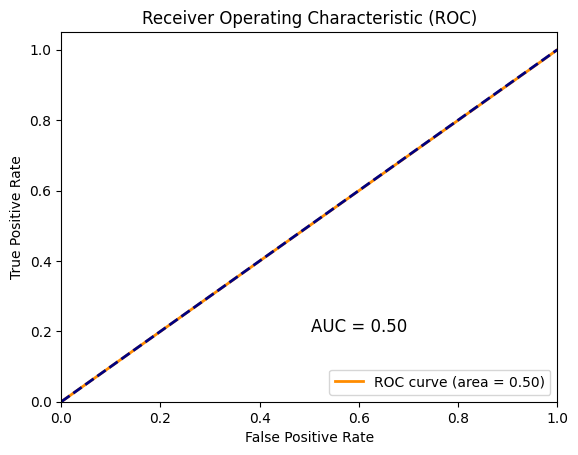

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your model predictions and true labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.text(0.6, 0.2, 'AUC = %0.2f' % roc_auc, ha='center', fontsize=12)
plt.show()


In [ ]:
'''TESTING'''
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# num_data = 10000
# input_dim = 46  # Assuming your input data has 10 features
# X_test = torch.randn(num_data, input_dim)  # Random values between -1 and 1
# t = torch.tensor(X_test, dtype=torch.float32)
X_test_df = test_df.drop(columns=['label'], axis=1).values
Y_test_df = test_df['label'].values
X_test = torch.tensor(X_test_df, dtype=torch.float32)
t = X_test.clone().detach()
test_dataset = TensorDataset(t)
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
all_predictions = []
with torch.no_grad():  # No need to compute gradients during inference
    for batch_data in test_loader:
        # Forward pass
        batch_outputs = model(batch_data[0])
        batch_predictions = (batch_outputs > 0.5).squeeze().numpy()
        all_predictions.append(batch_predictions)

# Concatenate predictions from all batches
predictions = np.concatenate(all_predictions)

# Print predictions
# print("Predictions:", predictions)

correct_predictions = np.sum(predictions == Y_test_df)
total_samples = len(Y_test_df)
accuracy = correct_predictions / total_samples

print("Accuracy:", accuracy)
